# Coding Assignment 5

```
Evaluation Metrices
Dataset: Pima Indians Diabetes Database
Author: Sreejith S
```

Dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database

Ref: [Machine Learning Model Evaluation Metrics](https://www.youtube.com/watch?v=wpQiEHYkBys)


In [72]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

%load_ext autoreload
%matplotlib inline
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 5.0. Loading dataset & Selecting features


Previously, it was observed that the four features, `plasma_glucose, serum_insulin, bmi, diab_pedigree` alone gave the best accuracy. We will work with these four features as our primary feature set in this notebook. 


In [4]:
#set pd display options
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 80)

# Importing the dataset
dataset = pd.read_csv('../datasets/pima-indians-diabetes.csv') 
print(dataset.shape)

#selecting features
f_best = ['plasma_glucose', 'serum_insulin', 'bmi', 'diab_pedigree']
f_4_3_a = ['age', 'pregnant', 'bmi']
f_4_3_b = ['skin_thickness', 'diab_pedigree', 'dia_BP']
f_all = ['pregnant', 'plasma_glucose', 'dia_BP', 'skin_thickness', 'serum_insulin', 'bmi', 'diab_pedigree', 'age']

X = dataset[f_best]
X_4_3_a = dataset[f_4_3_a]
X_4_3_b = dataset[f_4_3_b]
X_all = dataset.drop(columns=['Diab'])

f_list = [f_best, f_4_3_a, f_4_3_b, f_all]
y = dataset[['Diab']].values.ravel()

(768, 9)


#### Checking the extent of class imbalance

We note that there is slight inbalance `~ 35:65`, which is not terribly bad. However, this dataset is from a population that has a high prelavance of type 2 diabetes (US-Pima Indians). For other populations the class inbalance can be `~ 10:90` (taking into account the global diabetes occurance).

Expected dummy score ~ 0.65

In [194]:
y[y == 1].shape[0]/y.shape[0]

0.3489583333333333

## 5.1. Evaluation Metrices 

Evaluate metrices on the following models.
`DC-4`: `DummyClassifier` on `plasma_glucose, serum_insulin, bmi, diab_pedigree` (previous best feature set)

`LR-4`:  `LogisticRegression` on `plasma_glucose, serum_insulin, bmi, diab_pedigree`

`LR-4.3.a`: `LogisticRegression` on `age, #preg, bmi` 

`LR-4.3.b`: `LogisticRegression` on `skin_th, diab_pedigree, dia_BP` 

`LR-all`: `LogisticRegression` on `All features`

Since `DummyClassifier` with same `strategy` & `train_test_split` have similar metrics, it was not tested on other feature sets for brevity.


/home/sj/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


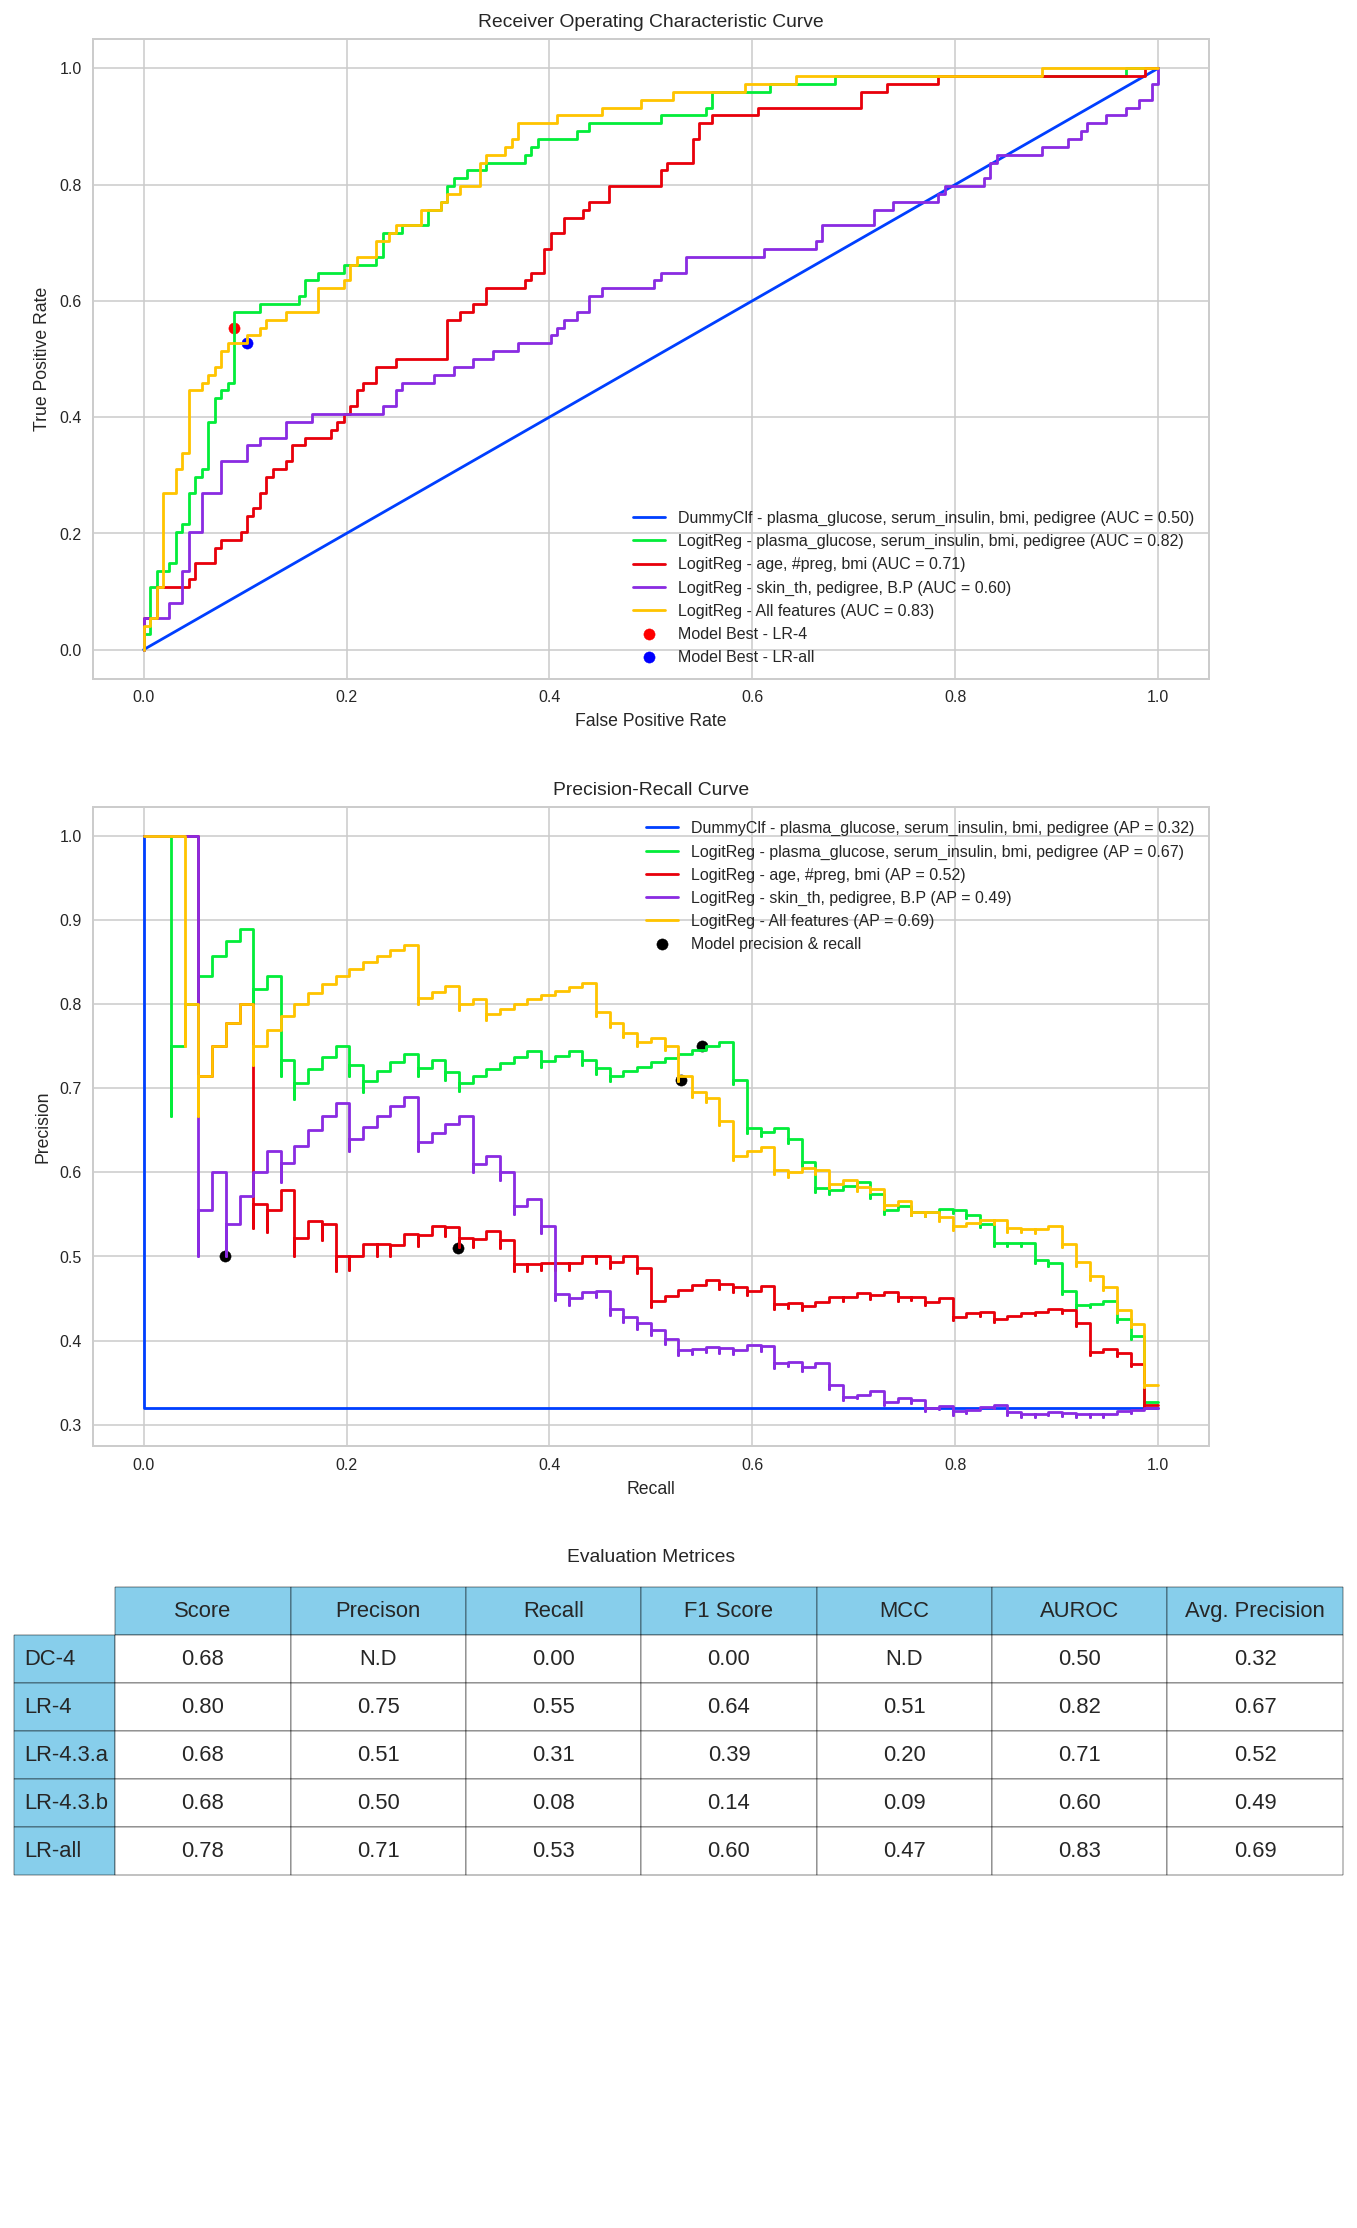

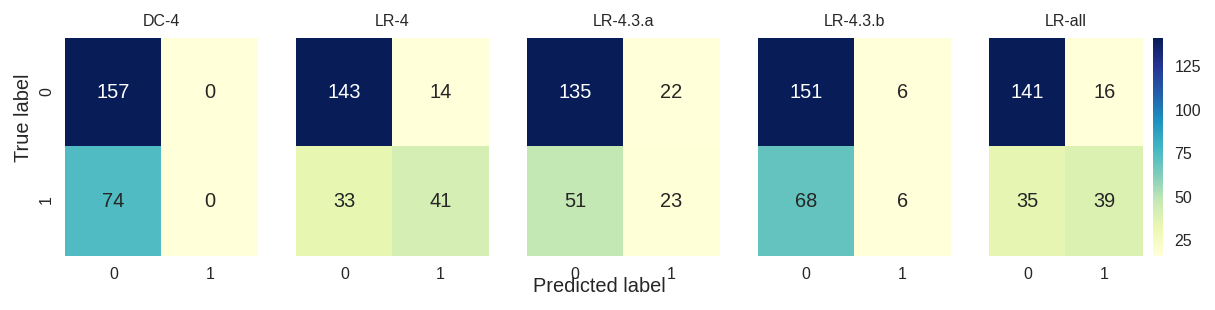

In [231]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
from sklearn.metrics import matthews_corrcoef, roc_curve, roc_auc_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from utils import plot_table, plot_confusion


short_titles = ["DC-4", "LR-4", "LR-4.3.a", "LR-4.3.b", "LR-all"]
titles = ["DummyClf - plasma_glucose, serum_insulin, bmi, pedigree", 
          "LogitReg - plasma_glucose, serum_insulin, bmi, pedigree", 
          "LogitReg - age, #preg, bmi", 
          "LogitReg - skin_th, pedigree, B.P", 
          "LogitReg - All features"]
feature_sets = [f_best, f_best, f_4_3_a, f_4_3_b, f_all]
y = dataset[['Diab']].values.ravel()
    
confusion_matrices = []
eval_metrics_list = []


fig = plt.figure(figsize=(10, 20))
plt.style.use("seaborn-whitegrid")
ax_roc = fig.add_subplot(3, 1, 1)
ax_roc.set_title("Receiver Operating Characteristic Curve")
ax_pre = fig.add_subplot(3, 1, 2)
ax_pre.set_title("Precision-Recall Curve")

#Plotting the actual precision and recall on the precision-recall plot
#These values were obtained from the table
ax_pre.scatter([0.31, 0.55, 0.08, 0.53],[0.51, 0.75, 0.50, 0.71], color='black', label='Model precision & recall')
ax_roc.scatter(0.089171, 0.554054, color='red', label='Model Best - LR-4')
ax_roc.scatter(0.1019, 0.5270, color='blue', label='Model Best - LR-all')


ax_table = fig.add_subplot(3, 1, 3)
ax_table.set_title("Evaluation Metrices")


for i, feature in enumerate(feature_sets):
        
    if i == 0:
        clf = DummyClassifier(strategy='most_frequent', random_state=0, )
    else:
        clf = LogisticRegression(max_iter=200)
    
    X = dataset[feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                      random_state=0)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    #fpr, tpr, threshold_roc = roc_curve(y_test, y_proba)
    #prec, recall, threshold_pre = precision_recall_curve(y_test, y_proba)

    
    plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name=titles[i])  
    plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pre, name=titles[i])
    
    confusion_matrices.append(confusion_matrix(y_test, y_preds))
    eval_metrics = [clf.score(X_test, y_test),
                    precision_score(y_test, y_preds, zero_division=0),
                    recall_score(y_test, y_preds),
                    f1_score(y_test, y_preds),
                    matthews_corrcoef(y_test, y_preds),
                    roc_auc_score(y_test, y_proba),
                    average_precision_score(y_test, y_proba)]
    eval_metrics = [f"{i:.2f}" for i in eval_metrics]
    if i == 0:
        #In case of DummyClassifier with strategy=most_frequent, precision & mcc are N.D
        eval_metrics[1] = "N.D" #Replace precision with N.D
        eval_metrics[4] = "N.D" #Replce MCC
    eval_metrics_list.append(eval_metrics)



ax_pre.legend(loc='upper right')
plot_table(eval_metrics_list, ax_table, short_titles)


plot_confusion(confusion_matrices, short_titles)

#fig = plt.figure(figsize=(10, 10))
#plt.hist(y_proba[np.where(y_test==1)], bins=100, density=True, alpha=0.6, color='g')
#plt.hist(y_proba[np.where(y_test==0)], bins=100, density=True, alpha=0.6, color='r')
plt.show()            




### Obeservations


**Which model is performing better?**

`LR-4` & `LR-all` performs better than all other models in every metric. While `LR-4` as better `precision=0.75` and `recall=0.55` when compared to the `precision=0.71` and `recall=0.53` of `LR-all`. 

Similarly, `LR-4` performs better when we consider `F1_score` & `MCC`. (We observe the sensitivity of the `F1_score` to flipping the class labels in Appendix A.)

When we consider `AUROC`, `LR-all` performs better. This means averaging over the possible thresholds, `LR-all` performs better than `LR-4`. But for the theshold the models actually use to predict `LR-4` performs best. In ROC plot, <span style="color:red">&#x25cf;</span> is plotted on the coordinates `(fpr, tpr)` calculated from `LR-4`'s confusion matrix. It can be observed that this is closes to the _ideal_ model's ROC value (top-left corner) when compared with that of `LR-all` (<span style="color:blue">&#x25cf;</span>).


**Why DummyClassifier has a score = `0.68`?** 

This conforms with out intial guess of `~0.65` in section `5.0 - checking for class imbalance`. The test set has `0.3 x 768` samples. From the confusion matrix `DC-4` we see that `157` predictions were true, ie; we get a score of `157/(0.3 x 768) = 0.68`. Hence, the score `0.68` is due to the inherent imbalance in the dataset and due to the fact that we are using `strategy=most_frequent`. It can be observed that by setting the parameter `strategy=uniform` several the metrices change.

**Why does DummyClassifier for all feature sets output the same metrics?**

This is due to the fact that for a particular `train_test_split`, the values of `y_labels` doesn't change. And since the DummyClassifier doesn't learn from training data, it is going to have the same evaluation scores. This also means we can use dummy classifier as a baseline. 

**Precision Score for DummyClassifier is Undefined.**

$$Precision Score = \frac{TP}{TP+FP}$$ and from the confusion matrix `DC-4` $$FP=TP=0$$

Similarly, `recall = 0`.

Interestingly, from the `precision-recall curve` we get `average_precision=0.32`, while the `precision=0` for the dummy classifier model. This is because, `average_precision` is calculated over all possible thresholds. 
If this has to do something with `74/(0.3 x 768) = 0.32`, has to be explored (where `74 is FN` from the confusion matrix `DC-4`).


### Misc Observations
**Why `4.3.b` curve goes under DC-4?**


### Appendix A

#### Flipping labels

It can be observed that every metrices except `MCC` and `AUROC` changes.
`ROC` plot is mirrored along the line `y=1-x`, but `AUROC` remains unchanged

/home/sj/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


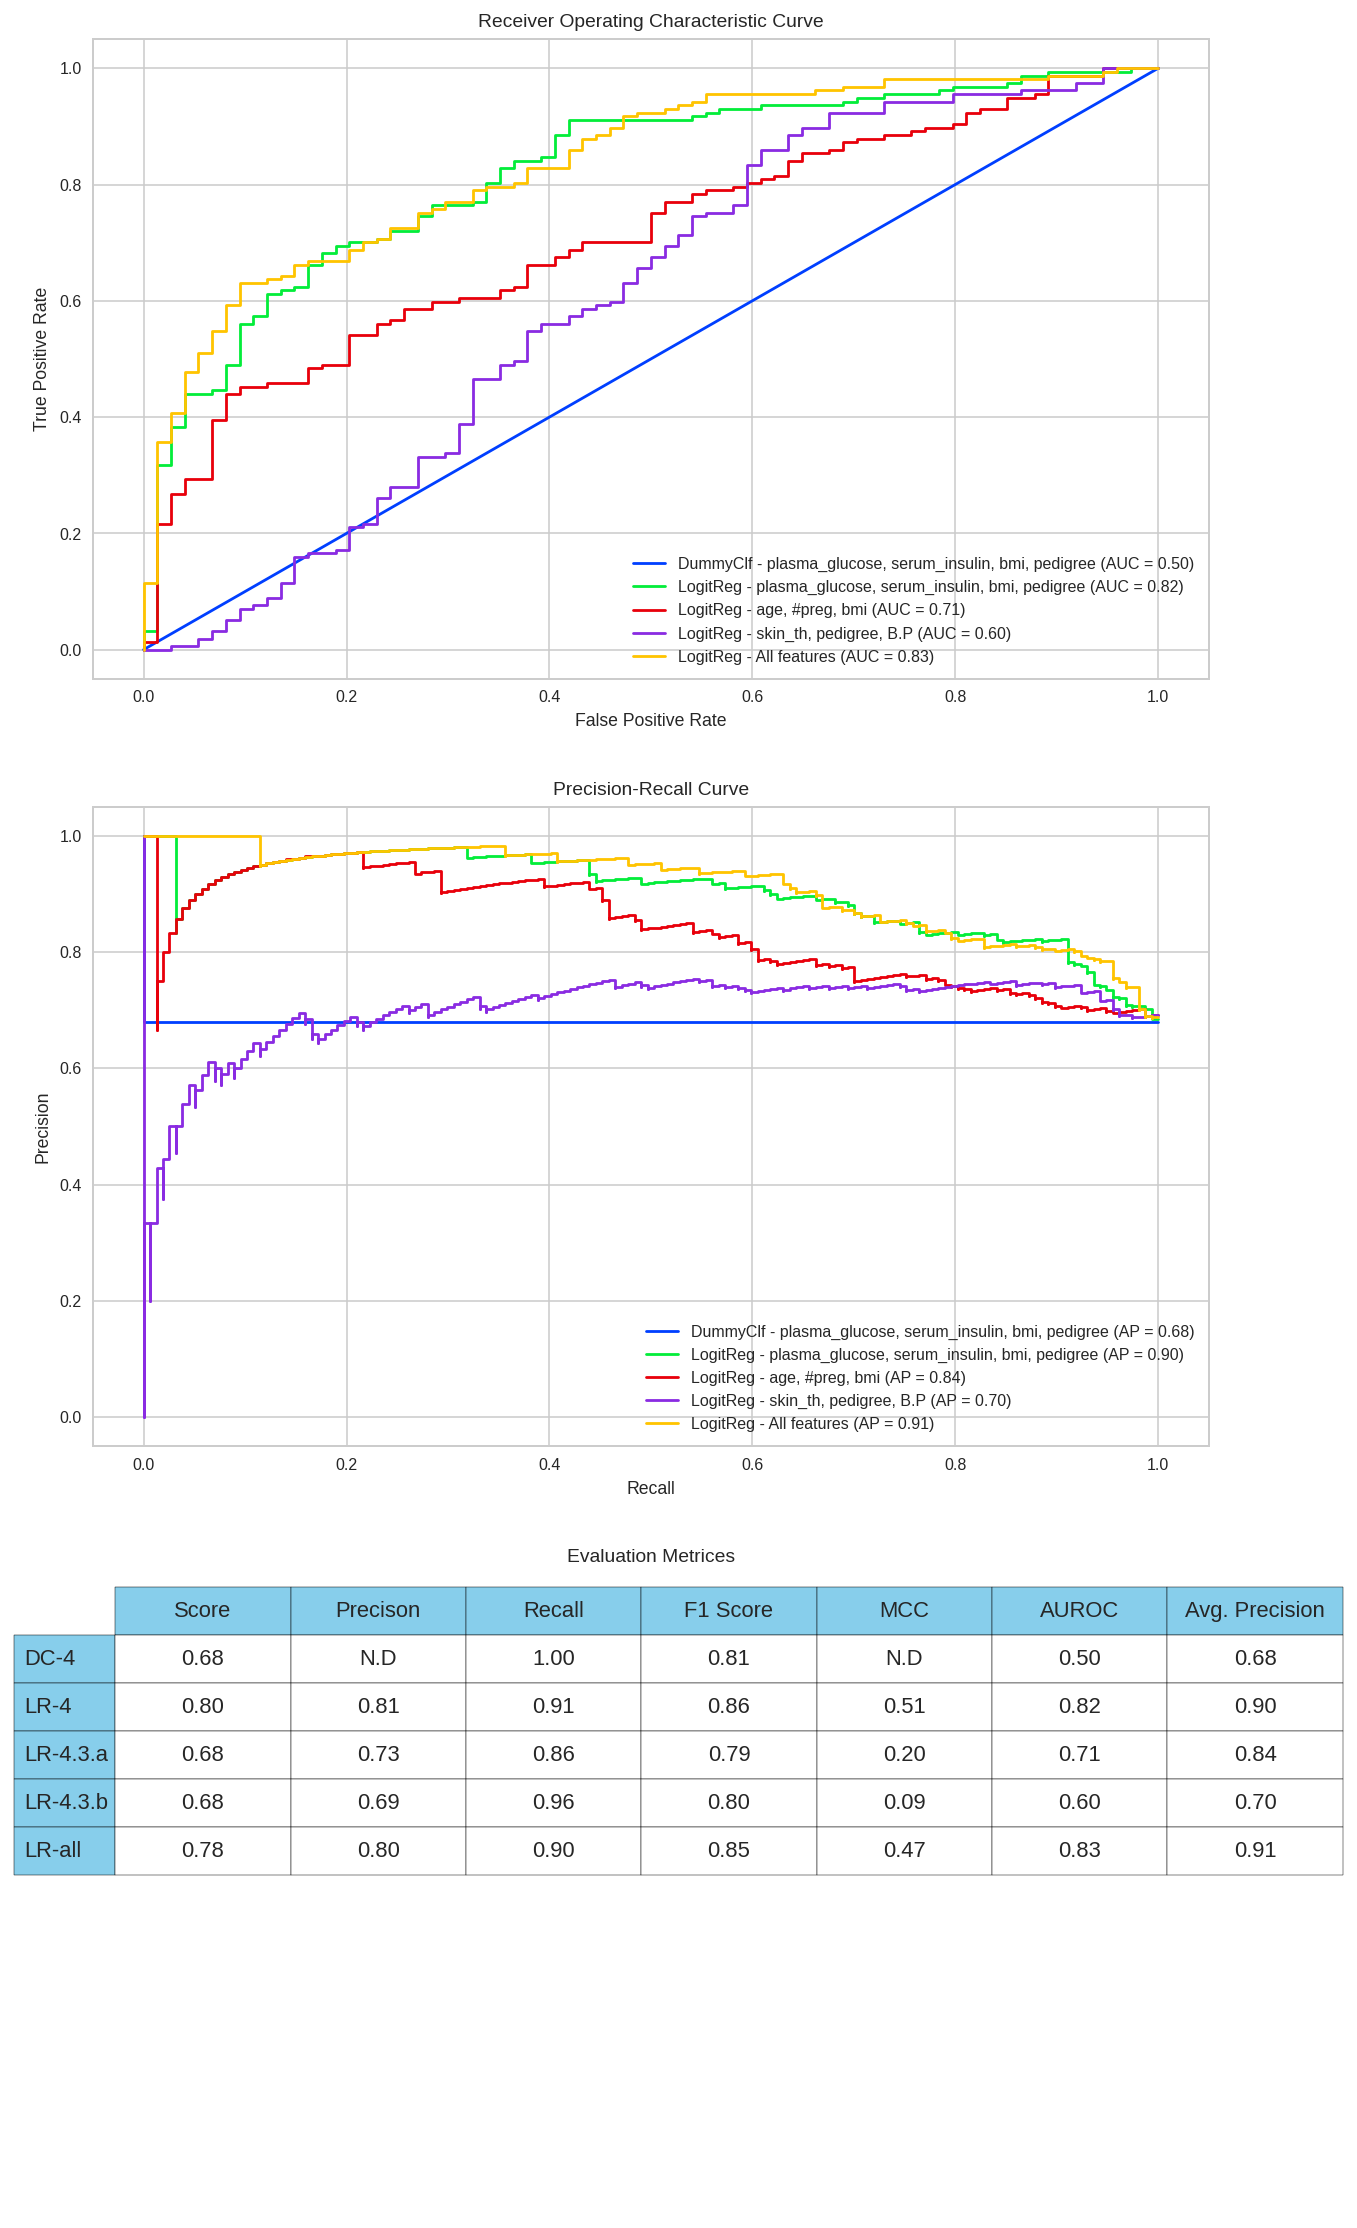

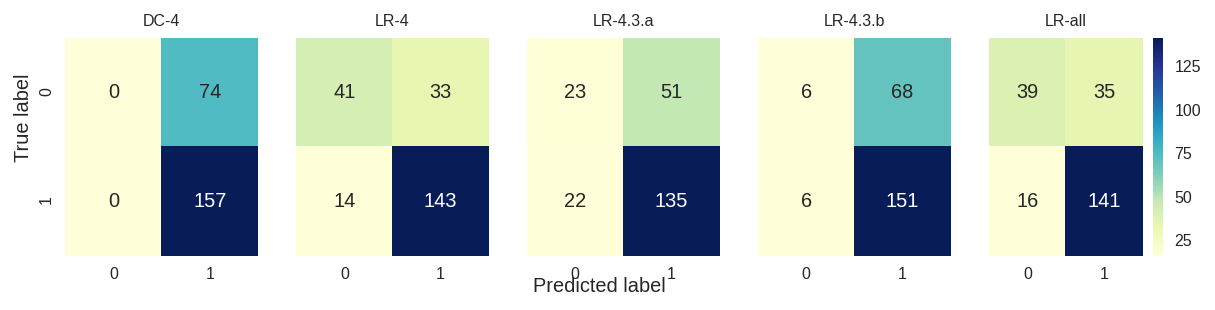

In [230]:
y_new = np.array([0 if i == 1 else 1 for i in y])
confusion_matrices = []
eval_metrics_list = []


fig = plt.figure(figsize=(10, 20))
plt.style.use("seaborn-whitegrid")
ax_roc = fig.add_subplot(3, 1, 1)
ax_roc.set_title("Receiver Operating Characteristic Curve")
ax_pre = fig.add_subplot(3, 1, 2)
ax_pre.set_title("Precision-Recall Curve")


ax_table = fig.add_subplot(3, 1, 3)
ax_table.set_title("Evaluation Metrices")


for i, feature in enumerate(feature_sets):
        
    if i == 0:
        clf = DummyClassifier(strategy='most_frequent', random_state=0, )
    else:
        clf = LogisticRegression(max_iter=200)
    
    X = dataset[feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.3, 
                                                      random_state=0)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    #fpr, tpr, threshold_roc = roc_curve(y_test, y_proba)
    #prec, recall, threshold_pre = precision_recall_curve(y_test, y_proba)

    
    plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name=titles[i])  
    plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pre, name=titles[i])
    
    confusion_matrices.append(confusion_matrix(y_test, y_preds))
    eval_metrics = [clf.score(X_test, y_test),
                    precision_score(y_test, y_preds, zero_division=0),
                    recall_score(y_test, y_preds),
                    f1_score(y_test, y_preds),
                    matthews_corrcoef(y_test, y_preds),
                    roc_auc_score(y_test, y_proba),
                    average_precision_score(y_test, y_proba)]
    eval_metrics = [f"{i:.2f}" for i in eval_metrics]
    if i == 0:
        #In case of DummyClassifier with strategy=most_frequent, precision & mcc are N.D
        eval_metrics[1] = "N.D" #Replace precision with N.D
        eval_metrics[4] = "N.D" #Replce MCC
    eval_metrics_list.append(eval_metrics)



ax_pre.legend(loc='lower right')
plot_table(eval_metrics_list, ax_table, short_titles)


plot_confusion(confusion_matrices, short_titles)

plt.show()            


### Appendix B
#### utils.py

In [ ]:
# %load utils.py
#!/bin/env python3

# Author: Sreejith S
# Date: Sat 26 Sep 2020 15:21:44 IST
#
# Plotting Utilities


import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import matthews_corrcoef
import seaborn as sns


def plot_table(eval_metrics_list, ax, titles):
    ax.set_axis_off()
    table = ax.table(
      cellText = eval_metrics_list,
      rowLabels = titles,
      colLabels = ["Score", "Precison", "Recall", "F1 Score", "MCC", "AUROC", "Avg. Precision"],
      rowColours =["skyblue"] * 5,
      colColours =["skyblue"] * 7,
      cellLoc = 'center',
      loc = 'upper left'
    )
    table.set_fontsize(15)
    table.scale(1.1, 2)
    #ax.text(0.5, 0.45, "text", ha="center" )

    
def plot_confusion(cf_matrices, titles):
    """
    Plot multiple cfm side by side:
    Ref : https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side
    """
    fig, axes = plt.subplots(1,5, sharex=True, sharey=True,figsize=(10,2))

    for i, ax in enumerate(axes.flat):
        sns.heatmap(cf_matrices[i], ax=ax,cbar=i==4, 
                    cmap="YlGnBu", annot=True, fmt="d")
        ax.set_title(titles[i],fontsize=8)

    fig.text(0.45, 0.0, 'Predicted label', ha='left')
    fig.text(0.1, 0.45, 'True label', ha='left', rotation=90, rotation_mode='anchor')
    
    
def plotter(dummy, logreg, X_test, y_test, dataset_title):
    """
    V0.0
    """
    y_pred_dummy = dummy.predict(X_test)
    y_pred_logreg = logreg.predict(X_test)
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,16))
    ax = axs.flatten()
    ax[0].set_title("DummyClassifier")
    plot_confusion_matrix(dummy, X_test, y_test,
                                        ax=ax[0],
                                        values_format='d',
                                        cmap=plt.cm.Blues)
    ax[1].set_title("LogisticRegression")
    plot_confusion_matrix(logreg, X_test, y_test,
                                        ax=ax[1],
                                        values_format='d',
                                        cmap=plt.cm.Blues)
    ax[2].set_title("ROC")
    plot_roc_curve(dummy, X_test, y_test, ax=ax[2])
    plot_roc_curve(logreg, X_test, y_test, ax=ax[2])
    #conf_mat_disp.ax_.set_title("Dummy Classifier (strategy='most_frequent')")
    #roc_disp.ax_.set_title("ROC")


    mets = [[dummy.score(X_test, y_test), logreg.score(X_test, y_test)],
          [precision_score(y_test, y_pred_dummy),
           precision_score(y_test, y_pred_logreg)],
          [recall_score(y_test, y_pred_dummy),
           recall_score(y_test, y_pred_logreg)],
          [f1_score(y_test, y_pred_dummy),
           f1_score(y_test, y_pred_logreg)],
          [matthews_corrcoef(y_test, y_pred_dummy),
           matthews_corrcoef(y_test, y_pred_logreg)]]
    table_cells = [[f"{j:.2f}" for j in i] for i in mets]
    table_cells[1][0] = "N.D"
    table_cells[4][0] = "N.D"
    print(table_cells)

    ax[3].set_axis_off()
    table = ax[3].table(
      cellText = table_cells,
      rowLabels = ["Score", "Precison", "Recall", "F1 Score", "MCC"],
      colLabels = ["DummyClassifier", "LogisticRegression"],
      rowColours =["skyblue"] * 5,
      colColours =["skyblue"] * 2,
      cellLoc = 'center',
      loc = 'upper left'
    )
    table.set_fontsize(15)
    table.scale(1.1, 2)
    ax[3].set_title(f"Evaluation Metrices for {dataset_title}")
    plt.suptitle(dataset_title)
    plt.show()

    
    
def test_models(dataset, f_list, test_size=0.3, random_state=0):
    """
    V0.0
    """
    #dummy_first_plot = True
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey='row')
    ax = axs.flatten()
    
    for i, f in enumerate(f_list):
        X = dataset[f]
        y = dataset[['Diab']].values.ravel()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                      random_state=random_state)
        
        
        if i == 0:
            #All dummy Classifier metrices are going to be same for splits with same random_state 
            dummy = DummyClassifier(strategy='most_frequent', random_state=0)
            dummy.fit(X_train, y_train)
            y_pred_dummy = dummy.predict(X_test)
            cfm = confusion_matrix(y_test, y_pred_dummy)
            cfm_disp = ConfusionMatrixDisplay(cfm)
            cfm_disp.plot(ax=ax[0])
            cfm_disp.ax_.set_title("DummyClassifier")
            cfm_disp.im_.colorbar.remove()
            cfm_disp.ax_.set_xlabel('')
                   
        cfm_disp.ax_.set_ylabel('')
            
            
        logreg = LogisticRegression(max_iter=200)
        logreg.fit(X_train, y_train)
        y_pred_logreg = logreg.predict(X_test)
        cfm = confusion_matrix(y_test, y_pred_logreg)
        cfm_disp = ConfusionMatrixDisplay(cfm)
        cfm_disp.plot(ax=ax[i+1])
        #cfm_disp.ax_.set_title("DummyClassifier")
        cfm_disp.im_.colorbar.remove()
        cfm_disp.ax_.set_xlabel('')
        
        
    fig.text(0.4, 0.1, 'Predicted label', ha='left')
    fig.text(0.1, 0.45, 'True label', ha='left', rotation=90, rotation_mode='anchor')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    fig.colorbar(cfm_disp.im_, ax=axs)
    plt.ylabel('')
    plt.show()

